# Vietnamese to English MT



* I. Data Reading and Tokenization
* II. Data Visualization
* III. Model Defination
* IV. Model Storage 
* V. Evaluating Elbow
* VI. Demo

### Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# I. Data Reading and Tokenization

## 1.1 Reading training set

In [2]:
data = pd.read_csv("/kaggle/input/my-data/new_train_ds.csv")
data = data.dropna()
data.head(10)

,en,vi,source
0,"- Sorry, that question's not on here.","- Xin lỗi, nhưng mà ở đây không có câu hỏi đấy.",OpenSubtitles v2018
1,He wants you to come with him immediately.,Ông ấy muốn bố đi với ông ấy ngay lập tức,OpenSubtitles v2018
2,I thought we could use some company.,Tôi nghĩ chúng ta có thể muốn vài người bạn đồ...,OpenSubtitles v2018
3,It was founded in 2008 by this anonymous progr...,Nó được sáng lập vào năm 2008 bởi một lập trìn...,TED2020 v1
4,"With both of these methods, no two prints are ...","Với cả hai phương pháp, không có hai bản in nà...",TED2020 v1
5,From these contexts was born an installation i...,Từ những tình huống này một bố trí không gian ...,TED2020 v1
6,I have lived to see something which I never ex...,Ta đã sống để thấy điều ta không bao giờ mong ...,OpenSubtitles v2018
7,It is the model for all future relationships w...,Đó là mô hình cho tất cả các mối quan hệ trong...,TED2020 v1
8,Welcome him as your brother.,Chào mừng nó như anh em của các con.,OpenSubtitles v2018
9,So biologists can make all the mutant fruit fl...,Vậy các nhà sinh vật học có thể biến đổi gene ...,TED2020 v1


## 1.2 Reading test set

In [3]:
test_data = pd.read_csv("/kaggle/input/my-data/test_ds.csv")
test_data = test_data.dropna()
data.head(5)

,en,vi,source
0,"- Sorry, that question's not on here.","- Xin lỗi, nhưng mà ở đây không có câu hỏi đấy.",OpenSubtitles v2018
1,He wants you to come with him immediately.,Ông ấy muốn bố đi với ông ấy ngay lập tức,OpenSubtitles v2018
2,I thought we could use some company.,Tôi nghĩ chúng ta có thể muốn vài người bạn đồ...,OpenSubtitles v2018
3,It was founded in 2008 by this anonymous progr...,Nó được sáng lập vào năm 2008 bởi một lập trìn...,TED2020 v1
4,"With both of these methods, no two prints are ...","Với cả hai phương pháp, không có hai bản in nà...",TED2020 v1


In [4]:
print(data.shape)
print(test_data.shape)

(2884451, 3)
(22541, 3)


## 1.3 Addining start and end token

In [5]:
# Append <START> and <END> to each english sentence
START = 'ssss '
END = ' eeee'

data['en'] = data['en'].apply(lambda x: START+x+END)
data.head()

,en,vi,source
0,"ssss - Sorry, that question's not on here. eeee","- Xin lỗi, nhưng mà ở đây không có câu hỏi đấy.",OpenSubtitles v2018
1,ssss He wants you to come with him immediately...,Ông ấy muốn bố đi với ông ấy ngay lập tức,OpenSubtitles v2018
2,ssss I thought we could use some company. eeee,Tôi nghĩ chúng ta có thể muốn vài người bạn đồ...,OpenSubtitles v2018
3,ssss It was founded in 2008 by this anonymous ...,Nó được sáng lập vào năm 2008 bởi một lập trìn...,TED2020 v1
4,"ssss With both of these methods, no two prints...","Với cả hai phương pháp, không có hai bản in nà...",TED2020 v1


In [6]:
eng_text = data['en'].tolist()
vi_text = data['vi'].tolist()

print(eng_text[3])
print(vi_text[3])


ssss It was founded in 2008 by this anonymous programmer using a pseudonym Satoshi Nakamoto. eeee
Nó được sáng lập vào năm 2008 bởi một lập trình viên vô danh dưới bút danh Satoshi Nakamoto.


In [7]:
num_words = 10000
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, padding,
                 reverse=False, num_words=None):
        """
        :param texts: List of strings. This is the data-set.
        :param padding: Either 'post' or 'pre' padding.
        :param reverse: Boolean whether to reverse token-lists.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

        # Convert all texts to lists of integer-tokens.
        # Note that the sequences may have different lengths.
        self.tokens = self.texts_to_sequences(texts)

        if reverse:
            # Reverse the token-sequences.
            self.tokens = [list(reversed(x)) for x in self.tokens]
        
            # Sequences that are too long should now be truncated
            # at the beginning, which corresponds to the end of
            # the original sequences.
            truncating = 'pre'
        else:
            # Sequences that are too long should be truncated
            # at the end.
            truncating = 'post'

        # The number of integer-tokens in each sequence.
        self.num_tokens = [len(x) for x in self.tokens]

        # Max number of tokens to use in all sequences.
        # We will pad / truncate all sequences to this length.
        # This is a compromise so we save a lot of memory and
        # only have to truncate maybe 5% of all the sequences.
        self.max_tokens = np.mean(self.num_tokens) \
                          + 2 * np.std(self.num_tokens)
        self.max_tokens = int(self.max_tokens)

        # Pad / truncate all token-sequences to the given length.
        # This creates a 2-dim numpy matrix that is easier to use.
        self.tokens_padded = pad_sequences(self.tokens,
                                           maxlen=self.max_tokens,
                                           padding=padding,
                                           truncating=truncating)

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def text_to_tokens(self, text, reverse=False, padding=False):
        """
        Convert a single text-string to tokens with optional
        reversal and padding.
        """

        # Convert to tokens. Note that we assume there is only
        # a single text-string so we wrap it in a list.
        tokens = self.texts_to_sequences([text])
        tokens = np.array(tokens)

        if reverse:
            # Reverse the tokens.
            tokens = np.flip(tokens, axis=1)

            # Sequences that are too long should now be truncated
            # at the beginning, which corresponds to the end of
            # the original sequences.
            truncating = 'pre'
        else:
            # Sequences that are too long should be truncated
            # at the end.
            truncating = 'post'

        if padding:
            # Pad and truncate sequences to the given length.
            tokens = pad_sequences(tokens,
                                   maxlen=self.max_tokens,
                                   padding='pre',
                                   truncating=truncating)

        return tokens

In [8]:
%%time
tokenizer_src = TokenizerWrap(texts=vi_text,
                              padding='pre',
                              reverse=True,
                              num_words=num_words
                             )

CPU times: user 3min 17s, sys: 1.19 s, total: 3min 18s
Wall time: 3min 18s


In [9]:
%%time
tokenizer_des = TokenizerWrap(texts=eng_text,
                              padding='post',
                              reverse=False,
                              num_words=num_words
                             )

CPU times: user 2min 25s, sys: 753 ms, total: 2min 25s
Wall time: 2min 25s


# II. Data Visualization

## 2.1 Create frequence dictionary

In [10]:
from collections import defaultdict
from pprint import pprint

num_words = 10000

# Khởi tạo đối tượng TokenizerWrap cho tiếng Anh
tokenizer_eng = tokenizer_des
# Khởi tạo đối tượng TokenizerWrap cho tiếng Việt
tokenizer_vi = tokenizer_src

In [11]:
# Bước 1: Chuyển đổi toàn bộ dữ liệu thành danh sách các token số nguyên
tokens_eng = tokenizer_eng.tokens
tokens_vi = tokenizer_vi.tokens

# Bước 2: Tạo từ điển tần suất cho từng ngôn ngữ
def create_frequency_dict(tokens, tokenizer):
    frequency_dict = defaultdict(int)
    for sentence in tokens:
        for token in sentence:
            word = tokenizer.index_to_word[token]
            frequency_dict[word] += 1
    return frequency_dict
def print_samples(frequency_dict, lang):
    samples = random.sample(list(frequency_dict.items()), 5)
    print(f"Samples from {lang} frequency dictionary:")
    for word, freq in samples:
        print(f"{word}: {freq}")

In [12]:
# Tạo từ điển tần suất cho tiếng Anh và tiếng Việt
frequency_dict_eng = create_frequency_dict(tokens_eng, tokenizer_eng)
frequency_dict_vi = create_frequency_dict(tokens_vi, tokenizer_vi)


In [13]:
print(f'number of unique English word: {len(frequency_dict_eng)}')
print_samples(frequency_dict_eng, "English")
print(f'number of unique Viet Nam word: {len(frequency_dict_vi)}')
print_samples(frequency_dict_vi, "Vietnamese")


number of unique English word: 9999
Samples from English frequency dictionary:
one's: 2024
pollution: 904
it's: 97852
looks: 5806
manipulate: 273
number of unique Viet Nam word: 9999
Samples from Vietnamese frequency dictionary:
federer: 96
hanja: 103
cinema: 100
interpol: 126
bướm: 1031


## 2.2 Word cloud visualizaiton

In [14]:
!pip install wordcloud matplotlib

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def create_wordcloud(frequency_dict, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequency_dict)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()



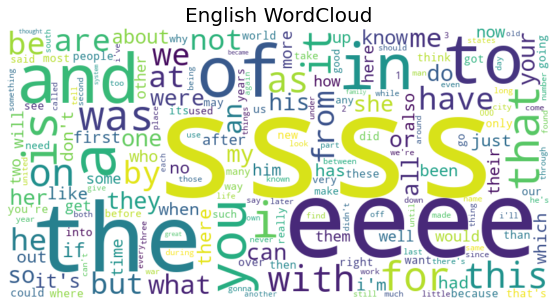

In [16]:
# Hiển thị WordCloud cho tiếng Anh
create_wordcloud(frequency_dict_eng, "English WordCloud")

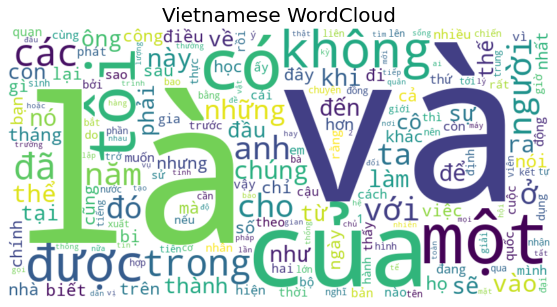

In [17]:
# Hiển thị WordCloud cho tiếng Việt
create_wordcloud(frequency_dict_vi, "Vietnamese WordCloud")

## 2.3 Bar chart visualization

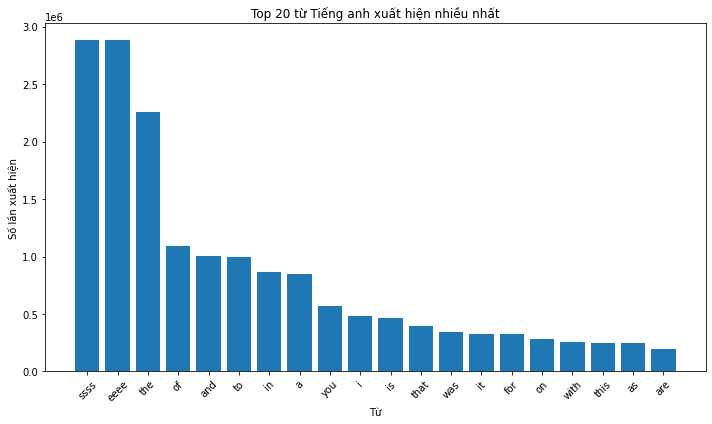

In [18]:
import matplotlib.pyplot as plt
from collections import defaultdict


top_words = sorted(frequency_dict_eng.items(), key=lambda x: x[1], reverse=True)[:20]

# Tách từ và tần suất
words, counts = zip(*top_words)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xlabel('Từ')
plt.ylabel('Số lần xuất hiện')
plt.title('Top 20 từ Tiếng anh xuất hiện nhiều nhất')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

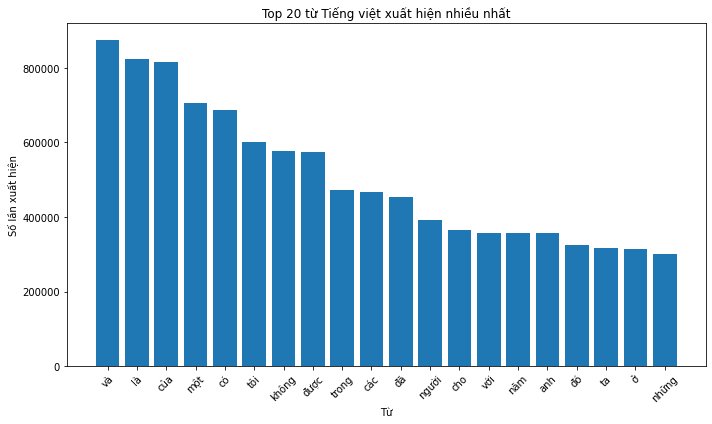

In [19]:
import matplotlib.pyplot as plt
from collections import defaultdict


top_words = sorted(frequency_dict_vi.items(), key=lambda x: x[1], reverse=True)[:20]

# Tách từ và tần suất
words, counts = zip(*top_words)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xlabel('Từ')
plt.ylabel('Số lần xuất hiện')
plt.title('Top 20 từ Tiếng việt xuất hiện nhiều nhất')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# III. Model Definition

In [20]:
token_src = tokenizer_src.tokens_padded
token_des = tokenizer_des.tokens_padded

print(token_src.shape)
print(token_des.shape)
token_start = tokenizer_des.word_index[START.strip()]
token_end = tokenizer_des.word_index[END.strip()]

(2884451, 43)
(2884451, 32)


In [21]:
encoder_inp_data = token_src
decoder_inp_data = token_des[:, :-1]
decoder_out_data = token_des[:, 1:]

### Encoder Model

In [22]:
# Glue all the encoder components together
def connect_encoder():
    net = encoder_input
    net = encoder_emb(net)
    net = encoder_gru1(net)
    net = encoder_gru2(net)
    out = encoder_gru3(net)
    
    return out

### Decoder Model

In [23]:
def connect_decoder(initial_state):    
    # Start the decoder-network with its input-layer.
    net = decoder_input

    # Connect the embedding-layer.
    net = decoder_emb(net)
    
    # Connect all the GRU-layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [24]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [25]:
# Connect all the models
with strategy.scope():
    
    embedding_size = 128
    state_size = 512

    encoder_input = Input(shape=(None,), name='encoder_input')
    encoder_emb = Embedding(input_dim=num_words, output_dim=embedding_size, name='encoder_embedding')

    encoder_gru1 = GRU(state_size, name='enc_gru1', return_sequences=True)
    encoder_gru2 = GRU(state_size, name='enc_gru2', return_sequences=True)
    encoder_gru3 = GRU(state_size, name='enc_gru3', return_sequences=False)
    
    encoder_op = connect_encoder()
    
    # Initial state placeholder takes a "thought vector" produced by the GRUs
    # That's why it needs the inputs with "state_size" (which was used in GRU size)
    decoder_initial_state = Input(shape=(state_size,), name='decoder_init_state')

    # Decoder also needs an input, which is the basic input setence of the destination language
    decoder_input = Input(shape=(None,), name='decoder_input')

    # Have the decoder embedding
    decoder_emb = Embedding(input_dim=num_words, output_dim=embedding_size, name='decoder_embedding')

    # GRU arch similar to Encoder one with small changes
    decoder_gru1 = GRU(state_size, name='dec_gru1', return_sequences=True)
    decoder_gru2 = GRU(state_size, name='dec_gru2', return_sequences=True)
    decoder_gru3 = GRU(state_size, name='dec_gru3', return_sequences=True)

    # Final dense layer for prediction
    decoder_dense = Dense(num_words, activation='softmax', name='decoder_output')
    decoder_op = connect_decoder(encoder_op)
    model_train = Model(inputs=[encoder_input, decoder_input],
                        outputs=[decoder_op])
    model_train.compile(optimizer=RMSprop(learning_rate=1e-3),
                        loss='sparse_categorical_crossentropy')

**kiếm tra check point có tồn tại ( sử dụng để train model không liên tục, mỗi lần train 1 ít, khi train xong, lưu model vào checkpoint và sau load lại)**

In [26]:
path_checkpoint = '/kaggle/input/my-data/data_3M_train_checkpoint_41to50.keras'
path_stored_checkpoint = "data_3M_train_checkpoint_51.keras"

# Tạo callback để lưu checkpoint mới
callback_checkpoint = ModelCheckpoint(filepath=path_stored_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [27]:
try:
    model_train.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [28]:
x_data = {
    "encoder_input": encoder_inp_data,
    "decoder_input": decoder_inp_data
}

y_data = {
    "decoder_output": decoder_out_data
}

In [29]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
callbacks = [callback_early_stopping,
             callback_checkpoint]

**Skip tới bước demo nếu không cần chạy lại training**

## Training model

In [30]:

# with strategy.scope():
#     model_train.fit(
#         x=x_data,
#         y=y_data,
#         batch_size=512,
#         epochs=10,
#         callbacks=callbacks
#     )
    

epoch 1: 

#  IV. Evaluating with BLEU Score

## 1. Tải và tiền xử lý bộ test

In [31]:
print(test_data.shape)
test_data = test_data[['en','vi']]
test_data.head(10)

(22541, 3)


,en,vi
0,"In August 1764, Bertin permitted the export of...","Tháng 8 năm 1764, Bertin lại cho phép xuất khẩ..."
1,Homeless women used to be invisible to me but ...,Tôi từng không hề để ý đến những người phụ nữ ...
2,Pumping water site for artificial infiltration...,Bơm nước cho thấm nhân tạo ở quận Sojovice.
3,I can't end it like this.,Tôi không thể kết thúc chuyện này như vậy.
4,"Well, I guess it's done then.","Vậy, ta đoán chúng ta đã xong."
5,"Okay. ""Release by"" ""Rotating""-","Được rồi. ""Phóng thích bằng cách"" - ""Xoay"" - c..."
6,Progress from 2000 onwards from IMF–OECD–FATF ...,Tiến bộ từ năm 2000 trở đi từ các sáng kiến IM...
7,"I'm sorry, Adem, about the loss of your wife.","Tôi rất tiếc, Adem, vì cái chết của vợ anh."
8,"Here we have Qatar today, and there we have Ba...","Ở đây chúng ta có Qatar hiện tại, và ở kia ta ..."
9,They seemed so... so human...,Chúng trông rất rất con người...


In [32]:
import numpy as np
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu_score(model, tokenizer_src, tokenizer_des, dataset, max_decoder_length=50):
    # Khởi tạo danh sách để lưu trữ kết quả
    references = []
    hypotheses = []
    
    # Danh sách để lưu trữ các dự đoán
    predictions = []

    for index, row in dataset.iterrows():
        # Lấy câu tiếng Việt và tiếng Anh
        input_sentence = row['vi']
        reference_sentence = row['en'].lower()

        # Chuyển đổi câu thành tokens
        input_tokens = tokenizer_src.text_to_tokens(input_sentence, reverse=True, padding=True)

        # Tạo đầu vào cho decoder
        decoder_input = np.zeros((1, max_decoder_length))
        decoder_input[0, 0] = token_start

        # Dự đoán câu dịch
        for t in range(1, max_decoder_length):
            output_tokens = model.predict([input_tokens, decoder_input])
            sampled_token_index = np.argmax(output_tokens[0, t-1, :])
            decoder_input[0, t] = sampled_token_index

            # Dừng lại nếu gặp token <END>
            if sampled_token_index == token_end:
                break

        # Chuyển đổi token thành chuỗi
        translated_sentence = tokenizer_des.tokens_to_string(decoder_input[0])

        # Thêm vào danh sách tham chiếu và giả thuyết
        references.append([reference_sentence.split()])  # Tham chiếu cần là danh sách các từ
        hypotheses.append(translated_sentence.split()[1:-1])
        
        # Lưu dự đoán
        predictions.append(translated_sentence)

    # Tính điểm BLEU
    bleu_score = corpus_bleu(references, hypotheses)

    # Tạo DataFrame mới với các cột 'vi', 'en', 'predict'
    results_df = pd.DataFrame({
        'vi': dataset['vi'],
        'en': dataset['en'],
        'predict': predictions,
        'hypotheses' : hypotheses,
        'references' : references
    })

    # Đổi thứ tự cột
    results_df = results_df[['vi', 'en', 'predict','hypotheses','references']]
    
    return bleu_score, results_df

model = model_train
bleu_score, results_df = calculate_bleu_score(model, tokenizer_src, tokenizer_des, test_data)

## 2. Dịch các câu và tính điểm BLEU trong bộ test

In [33]:
print(f"BLEU score: {bleu_score}")

BLEU score: 0.12812779932151572


In [34]:
results_df.head(10)

,vi,en,predict,hypotheses,references
0,"Tháng 8 năm 1764, Bertin lại cho phép xuất khẩ...","In August 1764, Bertin permitted the export of...",ssss in august of the year allowed for grain e...,"[in, august, of, the, year, allowed, for, grai...","[[in, august, 1764,, bertin, permitted, the, e..."
1,Tôi từng không hề để ý đến những người phụ nữ ...,Homeless women used to be invisible to me but ...,ssss i never noticed any of the women but now ...,"[i, never, noticed, any, of, the, women, but, ...","[[homeless, women, used, to, be, invisible, to..."
2,Bơm nước cho thấm nhân tạo ở quận Sojovice.,Pumping water site for artificial infiltration...,ssss artificial in the eeee,"[artificial, in, the]","[[pumping, water, site, for, artificial, infil..."
3,Tôi không thể kết thúc chuyện này như vậy.,I can't end it like this.,ssss i can't finish this eeee,"[i, can't, finish, this]","[[i, can't, end, it, like, this.]]"
4,"Vậy, ta đoán chúng ta đã xong.","Well, I guess it's done then.",ssss then i guess we're done eeee,"[then, i, guess, we're, done]","[[well,, i, guess, it's, done, then.]]"
5,"Được rồi. ""Phóng thích bằng cách"" - ""Xoay"" - c...","Okay. ""Release by"" ""Rotating""-",ssss all right turn on by releasing something ...,"[all, right, turn, on, by, releasing, something]","[[okay., ""release, by"", ""rotating""-]]"
6,Tiến bộ từ năm 2000 trở đi từ các sáng kiến IM...,Progress from 2000 onwards from IMF–OECD–FATF ...,ssss the from 2000 to the standard of initiati...,"[the, from, 2000, to, the, standard, of, initi...","[[progress, from, 2000, onwards, from, imf–oec..."
7,"Tôi rất tiếc, Adem, vì cái chết của vợ anh.","I'm sorry, Adem, about the loss of your wife.",ssss i'm sorry for your death eeee,"[i'm, sorry, for, your, death]","[[i'm, sorry,, adem,, about, the, loss, of, yo..."
8,"Ở đây chúng ta có Qatar hiện tại, và ở kia ta ...","Here we have Qatar today, and there we have Ba...",ssss here we have qatar and here we are there ...,"[here, we, have, qatar, and, here, we, are, th...","[[here, we, have, qatar, today,, and, there, w..."
9,Chúng trông rất rất con người...,They seemed so... so human...,ssss they look very very very very very very v...,"[they, look, very, very, very, very, very, ver...","[[they, seemed, so..., so, human...]]"


# V. Demo

In [35]:
import numpy as np
# Ví dụ một câu tiếng Anh mới để dịch
new_sentences = [
    "Từ nơi đồng xanh thơm hương lúa, về nơi nhà cao xe giăng phố ",
    "Bạn khỏe không",
    "bạn thấy thế nào",
    "Học phát triển hệ thống thông minh",
    "Chào mừng đến với bình nguyên vô tận"
]
model = model_train
# Chuyển đổi các câu thành tokens
tokenized_inputs = [tokenizer_src.text_to_tokens(sentence, reverse=True, padding=True) for sentence in new_sentences]
# Dự đoán cho từng câu
max_decoder_length = 20  # Thay đổi giá trị này nếu cần
count = 0
for input_tokens in tokenized_inputs:
    # In cau goc
    print(f"Original sentence: {new_sentences[count]}")
    count +=1
    # Tạo đầu vào cho decoder
    decoder_input = np.zeros((1, max_decoder_length))  # Kích thước: (1, max_decoder_length)
    decoder_input[0, 0] = token_start  # Bắt đầu bằng token <START>

    # Lặp để dự đoán từng từ
    for t in range(1, max_decoder_length):
        output_tokens = model.predict([input_tokens, decoder_input])
        sampled_token_index = np.argmax(output_tokens[0, t-1, :])
        decoder_input[0, t] = sampled_token_index

        # Dừng lại nếu gặp token <END>
        if sampled_token_index == token_end:
            break

    # Chuyển đổi token thành chuỗi
    translated_sentence = tokenizer_des.tokens_to_string(decoder_input[0])
    print(f"Translated: {translated_sentence}")

Original sentence: Từ nơi đồng xanh thơm hương lúa, về nơi nhà cao xe giăng phố 
Translated: ssss from the green rice fields to the of the eeee
Original sentence: Bạn khỏe không
Translated: ssss how are you doing eeee
Original sentence: bạn thấy thế nào
Translated: ssss how are you feeling eeee
Original sentence: Học phát triển hệ thống thông minh
Translated: ssss learning to develop intelligent systems eeee
Original sentence: Chào mừng đến với bình nguyên vô tận
Translated: ssss welcome to the infinity eeee


# IV. Store all file and load model

## 6.1 Store all needed file

In [36]:
import pickle
from tensorflow.keras.models import load_model

# Lưu mô hình đã huấn luyện
model_train.save('model_train_50_epoch.h5')

# Lưu tokenizer cho tiếng Việt
with open('tokenizer_src.pkl', 'wb') as f:
    pickle.dump(tokenizer_src, f)

# Lưu tokenizer cho tiếng Anh
with open('tokenizer_des.pkl', 'wb') as f:
    pickle.dump(tokenizer_des, f)

# Lưu các token đặc biệt
special_tokens = {
    'token_start': token_start,
    'token_end': token_end
}
with open('special_tokens.pkl', 'wb') as f:
    pickle.dump(special_tokens, f)


## 6.2 Load the model and other component

In [37]:
import numpy as np
from tensorflow.keras.models import load_model
import pickle

# Load the trained model
model = load_model("/kaggle/working/model_train_50_epoch.h5")

# Load the tokenizers
with open('/kaggle/working/tokenizer_src.pkl', 'rb') as file:
    tokenizer_src = pickle.load(file)

with open('/kaggle/working/tokenizer_des.pkl', 'rb') as file:
    tokenizer_des = pickle.load(file)
with open('special_tokens.pkl', 'rb') as file:
    special_tokens = pickle.load(file)

START = special_tokens["token_start"]
END = special_tokens["token_end"]

## 6.3 Test with new data

In [38]:
new_sentences = [
    "Từ nơi đồng xanh thơm hương lúa, về nơi nhà cao xe giăng phố ",
    "Bạn khỏe không",
    "bạn thấy thế nào",
    "Học phát triển hệ thống thông minh",
    "Chào mừng đến với bình nguyên vô tận"
]
# Chuyển đổi các câu thành tokens
tokenized_inputs = [tokenizer_src.text_to_tokens(sentence, reverse=True, padding=True) for sentence in new_sentences]
# Dự đoán cho từng câu
max_decoder_length = 20  # Thay đổi giá trị này nếu cần
count = 0
for input_tokens in tokenized_inputs:
    # In cau goc
    print(f"Original sentence: {new_sentences[count]}")
    count +=1
    # Tạo đầu vào cho decoder
    decoder_input = np.zeros((1, max_decoder_length))  # Kích thước: (1, max_decoder_length)
    decoder_input[0, 0] = token_start  # Bắt đầu bằng token <START>

    # Lặp để dự đoán từng từ
    for t in range(1, max_decoder_length):
        output_tokens = model.predict([input_tokens, decoder_input])
        sampled_token_index = np.argmax(output_tokens[0, t-1, :])
        decoder_input[0, t] = sampled_token_index

        # Dừng lại nếu gặp token <END>
        if sampled_token_index == token_end:
            break

    # Chuyển đổi token thành chuỗi
    translated_sentence = tokenizer_des.tokens_to_string(decoder_input[0])
    print(f"Translated: {translated_sentence}")

Original sentence: Từ nơi đồng xanh thơm hương lúa, về nơi nhà cao xe giăng phố 
Translated: ssss from the green rice fields to the of the eeee
Original sentence: Bạn khỏe không
Translated: ssss how are you doing eeee
Original sentence: bạn thấy thế nào
Translated: ssss how are you feeling eeee
Original sentence: Học phát triển hệ thống thông minh
Translated: ssss learning to develop intelligent systems eeee
Original sentence: Chào mừng đến với bình nguyên vô tận
Translated: ssss welcome to the infinity eeee
